# Лабораторная работа №8
1.a датасет с дорожными знаками https://www.kaggle.com/datasets/andrewmvd/road-sign-detection/data \
Тематика датасета имеет практическую значимость в области автономного вождения и интеллектуальных транспортных систем
1.b выбранные метрики
-  mAP@0.5
-  mAP@0.5:0.95
- precision
- recall

тут аналогично как в ЛР7 скачиваем датасет с kaggle

In [ ]:
!pip install kaggle
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.1 MB/s eta 0:00:00


In [ ]:
from google.colab import files
files.upload()


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d andrewmvd/road-sign-detection
!unzip -q road-sign-detection.zip -d road-sign-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection
License(s): CC0-1.0


In [ ]:
import os
import xml.etree.ElementTree as ET

annotation_dir = "/content/road-sign-detection/annotations"
class_set = set()

for xml_file in os.listdir(annotation_dir):
    if not xml_file.endswith(".xml"):
        continue
    tree = ET.parse(os.path.join(annotation_dir, xml_file))
    root = tree.getroot()
    for obj in root.iter("object"):
        class_name = obj.find("name").text.strip()
        class_set.add(class_name)

classes = sorted(list(class_set))
class_dict = {name: idx for idx, name in enumerate(classes)}
classes

['crosswalk', 'speedlimit', 'stop', 'trafficlight']

In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

voc_path = "/content/road-sign-detection"
output_path = "/content/road-sign-yolo"
annotation_dir = os.path.join(voc_path, "annotations")
image_dir = os.path.join(voc_path, "images")

import shutil

if os.path.exists(output_path):
    shutil.rmtree(output_path)


os.makedirs(f"{output_path}/images/train", exist_ok=True)
os.makedirs(f"{output_path}/images/val", exist_ok=True)
os.makedirs(f"{output_path}/labels/train", exist_ok=True)
os.makedirs(f"{output_path}/labels/val", exist_ok=True)

images = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))]
train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)
print(f'изображений всего: {len(images)}')
print(f'train: {len(train_imgs)}')
print(f'val: {len(val_imgs)}')

изображений всего: 877
train: 701
val: 176


In [ ]:
def convert_bbox(size, box):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x * dw, y * dh, w * dw, h * dh)

def convert_annotation(image_name, subset):
    image_id = os.path.splitext(image_name)[0]
    xml_path = os.path.join(annotation_dir, f"{image_id}.xml")
    tree = ET.parse(xml_path)
    root = tree.getroot()

    size = root.find("size")
    w = int(size.find("width").text)
    h = int(size.find("height").text)

    out_file = open(f"{output_path}/labels/{subset}/{image_id}.txt", "w")
    for obj in root.iter("object"):
        cls = obj.find("name").text.strip()
        if cls not in class_dict:
            continue
        cls_id = class_dict[cls]
        xmlbox = obj.find("bndbox")
        b = [int(xmlbox.find("xmin").text), int(xmlbox.find("xmax").text),
             int(xmlbox.find("ymin").text), int(xmlbox.find("ymax").text)]
        bb = convert_bbox((w, h), b)
        out_file.write(f"{cls_id} {' '.join([str(round(a, 6)) for a in bb])}\n")
    out_file.close()

for subset, img_list in zip(["train", "val"], [train_imgs, val_imgs]):
    for img in img_list:
        shutil.copy(f"{image_dir}/{img}", f"{output_path}/images/{subset}/{img}")
        convert_annotation(img, subset)

yaml_path = os.path.join(output_path, "dataset.yaml")
with open(yaml_path, "w") as f:
    f.write(f"path: {output_path}\n")
    f.write("train: images/train\n")
    f.write("val: images/val\n")
    f.write("names:\n")
    for i, name in enumerate(classes):
        f.write(f"  {i}: {name}\n")

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(data="/content/road-sign-yolo/dataset.yaml", epochs=20, imgsz=640)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 113MB/s]


Ultralytics 8.3.115 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/road-sign-yolo/dataset.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, l

100%|██████████| 755k/755k [00:00<00:00, 24.9MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,628 parameters, 3,011,612 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 111MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2549.4±1669.1 MB/s, size: 220.8 KB)


train: Scanning /content/road-sign-yolo/labels/train... 701 images, 0 backgrounds, 0 corrupt: 100%|██████████| 701/701 [00:00<00:00, 1229.84it/s]

train: New cache created: /content/road-sign-yolo/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 918.8±959.3 MB/s, size: 223.3 KB)


val: Scanning /content/road-sign-yolo/labels/val... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<00:00, 676.03it/s]

val: New cache created: /content/road-sign-yolo/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.04G     0.7637      2.574     0.9396         37        640: 100%|██████████| 44/44 [00:17<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]

                   all        176        247          1      0.107      0.545      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.52G     0.7728      1.434     0.9574         31        640: 100%|██████████| 44/44 [00:15<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        176        247      0.885      0.409      0.678      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.54G     0.7712      1.276     0.9422         48        640: 100%|██████████| 44/44 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        176        247      0.502      0.721       0.64      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.55G     0.7422      1.163     0.9536         65        640: 100%|██████████| 44/44 [00:14<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        176        247      0.727      0.582      0.665      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.57G     0.7444      1.073     0.9514         35        640: 100%|██████████| 44/44 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        176        247      0.774      0.806      0.809      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.59G     0.7343     0.9691     0.9484         26        640: 100%|██████████| 44/44 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


                   all        176        247      0.719        0.8      0.728      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.61G     0.6995     0.8698     0.9349         24        640: 100%|██████████| 44/44 [00:14<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        176        247      0.901      0.777      0.834      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.62G     0.6921      0.826     0.9279         37        640: 100%|██████████| 44/44 [00:13<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        176        247      0.905      0.837      0.892      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.64G       0.68     0.7821     0.9368         27        640: 100%|██████████| 44/44 [00:14<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


                   all        176        247      0.918      0.865      0.892      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.66G     0.6688     0.7288     0.9179         37        640: 100%|██████████| 44/44 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]

                   all        176        247      0.925      0.828      0.888      0.725


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.68G     0.6387     0.7592     0.8863         20        640: 100%|██████████| 44/44 [00:15<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.22it/s]

                   all        176        247      0.873      0.835       0.87      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.69G     0.6266     0.7009     0.8962         19        640: 100%|██████████| 44/44 [00:13<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

                   all        176        247      0.959      0.829      0.887      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.71G     0.6005     0.6381     0.8765         20        640: 100%|██████████| 44/44 [00:13<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.00it/s]

                   all        176        247      0.914      0.816      0.864      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.72G     0.6033     0.6076     0.8728         20        640: 100%|██████████| 44/44 [00:13<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]

                   all        176        247      0.895      0.842      0.898      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.74G     0.5778     0.5686      0.872         16        640: 100%|██████████| 44/44 [00:13<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.18it/s]

                   all        176        247      0.927      0.845      0.911      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.76G     0.5676      0.546     0.8611         18        640: 100%|██████████| 44/44 [00:13<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all        176        247       0.89      0.892      0.914       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.78G     0.5554     0.5227     0.8537         15        640: 100%|██████████| 44/44 [00:13<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

                   all        176        247      0.922      0.864       0.91      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.79G     0.5456     0.4992     0.8608         16        640: 100%|██████████| 44/44 [00:13<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

                   all        176        247      0.933      0.862      0.903      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.81G     0.5288     0.4752     0.8403         18        640: 100%|██████████| 44/44 [00:13<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.21it/s]

                   all        176        247      0.944      0.878      0.911      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.83G     0.5168     0.4618     0.8468         18        640: 100%|██████████| 44/44 [00:13<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]

                   all        176        247      0.967      0.869      0.916      0.779



20 epochs completed in 0.094 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.115 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


                   all        176        247      0.967      0.869      0.917      0.778
             crosswalk         24         25      0.956      0.871      0.906      0.738
            speedlimit        141        168      0.996      0.988      0.995      0.903
                  stop         15         15          1          1      0.995      0.937
          trafficlight         22         39      0.917      0.615       0.77      0.534
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 7.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cf93b6055d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
metrics = model.val()
box = metrics.box

print(f"Precision    : {box.mp:.4f}")
print(f"Recall       : {box.mr:.4f}")
print(f"mAP@0.5      : {box.map50:.4f}")
print(f"mAP@0.5:0.95 : {box.map:.4f}")


Ultralytics 8.3.115 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1597.4±467.0 MB/s, size: 414.1 KB)


val: Scanning /content/road-sign-yolo/labels/val.cache... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.18it/s]


                   all        176        247      0.959      0.869      0.915      0.778
             crosswalk         24         25      0.956      0.871      0.906      0.736
            speedlimit        141        168      0.995      0.988      0.995      0.904
                  stop         15         15          1          1      0.995      0.943
          trafficlight         22         39      0.883      0.615      0.766      0.529
Speed: 3.0ms preprocess, 3.9ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train8
Precision    : 0.9586
Recall       : 0.8686
mAP@0.5      : 0.9154
mAP@0.5:0.95 : 0.7778


2.b модель продемонстрировала хорошие результаты: точность (Precision) составила 0.9586, полнота (Recall) — 0.8686, средняя точность по IoU=0.5 (mAP@0.5) — 0.9154, а усреднённая точность по диапазону IoU от 0.5 до 0.95 (mAP@0.5:0.95) — 0.7778

# 3 Улучшение бейзлайна
3.a улучшение бейзлайна с помощью подбора гиперпараметров

In [ ]:
model = YOLO("yolov8s.pt")

model.train(
    data="/content/road-sign-yolo/dataset.yaml",
    epochs=20,
    imgsz=960,
    batch=8,
    augment=True,
    cos_lr=True,
    lr0=0.005
)


100%|██████████| 21.5M/21.5M [00:00<00:00, 229MB/s]


Ultralytics 8.3.115 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/road-sign-yolo/dataset.yaml, epochs=20, time=None, patience=100, batch=8, imgsz=960, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, li

train: Scanning /content/road-sign-yolo/labels/train.cache... 701 images, 0 backgrounds, 0 corrupt: 100%|██████████| 701/701 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1405.4±1097.9 MB/s, size: 223.3 KB)


val: Scanning /content/road-sign-yolo/labels/val.cache... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<?, ?it/s]


Plotting labels to runs/detect/train10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to runs/detect/train10
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.23G     0.7817      2.244      1.033         13        960: 100%|██████████| 88/88 [00:31<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]

                   all        176        247      0.958      0.631      0.781      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.06G     0.8076       1.05      1.067         15        960: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

                   all        176        247       0.85       0.52      0.634      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.06G     0.8565     0.9798      1.074         23        960: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]

                   all        176        247      0.622      0.616        0.6      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.06G     0.8212     0.9133      1.067         16        960: 100%|██████████| 88/88 [00:29<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]

                   all        176        247      0.748      0.645      0.683      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.06G     0.7648     0.7687      1.028         15        960: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.01it/s]

                   all        176        247      0.803      0.756      0.765      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.06G     0.7633     0.7121      1.018         10        960: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]

                   all        176        247      0.851      0.777      0.824      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       6.1G      0.748     0.7479       1.03         14        960: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.06it/s]

                   all        176        247      0.754      0.775      0.808      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       6.1G     0.7066     0.6681      1.001         14        960: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]

                   all        176        247      0.886      0.813      0.892      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.13G     0.6952     0.6355     0.9926         13        960: 100%|██████████| 88/88 [00:30<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]

                   all        176        247      0.843      0.818      0.873      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.13G      0.696     0.5688     0.9872         10        960: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.96it/s]

                   all        176        247      0.919      0.806      0.898      0.745


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.13G     0.6426     0.4997     0.9539          7        960: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]

                   all        176        247      0.962      0.826      0.881       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.13G     0.6369     0.4927     0.9466          7        960: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.08it/s]

                   all        176        247       0.93      0.799      0.859      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.13G     0.6172     0.4482     0.9371          8        960: 100%|██████████| 88/88 [00:28<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.93it/s]

                   all        176        247      0.917      0.841      0.888      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.13G     0.5913     0.4133     0.9203          7        960: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.09it/s]

                   all        176        247      0.896      0.844      0.894      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.13G     0.5682     0.3933     0.9141          7        960: 100%|██████████| 88/88 [00:28<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]

                   all        176        247        0.9       0.88       0.91      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.13G     0.5602     0.3775     0.9007          9        960: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.45it/s]

                   all        176        247      0.946      0.849      0.914      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.13G     0.5417      0.358     0.8869          7        960: 100%|██████████| 88/88 [00:28<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]

                   all        176        247      0.921      0.871      0.933      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.13G     0.5267     0.3277     0.8981          6        960: 100%|██████████| 88/88 [00:28<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.86it/s]

                   all        176        247       0.93      0.869      0.933      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.13G     0.5241     0.3299     0.8921          6        960: 100%|██████████| 88/88 [00:28<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.96it/s]

                   all        176        247      0.929       0.86      0.931      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.13G     0.5127     0.3152      0.882          7        960: 100%|██████████| 88/88 [00:28<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.68it/s]

                   all        176        247      0.912       0.88      0.932      0.792



20 epochs completed in 0.186 hours.
Optimizer stripped from runs/detect/train10/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train10/weights/best.pt, 22.5MB

Validating runs/detect/train10/weights/best.pt...
Ultralytics 8.3.115 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


                   all        176        247       0.93      0.907      0.948      0.804
             crosswalk         24         25      0.864       0.88      0.916      0.751
            speedlimit        141        168      0.997      0.994      0.995       0.92
                  stop         15         15          1       0.98      0.995      0.941
          trafficlight         22         39      0.858      0.773      0.886      0.603
Speed: 0.4ms preprocess, 30.7ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/train10


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cf948179ed0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
metrics = model.val()
box = metrics.box

print(f"Precision    : {box.mp:.4f}")
print(f"Recall       : {box.mr:.4f}")
print(f"mAP@0.5      : {box.map50:.4f}")
print(f"mAP@0.5:0.95 : {box.map:.4f}")


Ultralytics 8.3.115 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1107.2±964.0 MB/s, size: 250.4 KB)


val: Scanning /content/road-sign-yolo/labels/val.cache... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.57it/s]


                   all        176        247       0.93      0.911      0.945      0.808
             crosswalk         24         25      0.864       0.88      0.916      0.765
            speedlimit        141        168      0.997      0.994      0.995       0.92
                  stop         15         15          1       0.98      0.995      0.941
          trafficlight         22         39      0.861      0.792      0.873      0.607
Speed: 2.5ms preprocess, 39.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train102
Precision    : 0.9304
Recall       : 0.9115
mAP@0.5      : 0.9447
mAP@0.5:0.95 : 0.8085


3.e  модель продемонстрировала хорошие результаты: точность (Precision) составила 0.0.9304, полнота (Recall) — 0.9304, средняя точность по IoU=0.5 (mAP@0.5) — 0.0.9447, а усреднённая точность по диапазону IoU от 0.5 до 0.95 (mAP@0.5:0.95) — 0.8085 \
3.f после улучшения бейзлайна - повышения разрешения изображений и расширения аугментаций, модель достигла ещё более высоких результатов \
3.g модель показывает хорошие результаты как на базовом бейзлайне, так и на улучшенном

In [ ]:
model.predict(source="/content/road-sign-yolo/images/val", save=True, conf=0.25)


image 1/176 /content/road-sign-yolo/images/val/road0.png: 960x672 (no detections), 58.2ms
image 2/176 /content/road-sign-yolo/images/val/road104.png: 896x960 1 speedlimit, 122.7ms
image 3/176 /content/road-sign-yolo/images/val/road105.png: 960x736 1 speedlimit, 114.9ms
image 4/176 /content/road-sign-yolo/images/val/road11.png: 736x960 2 trafficlights, 114.1ms
image 5/176 /content/road-sign-yolo/images/val/road111.png: 672x960 1 speedlimit, 114.3ms
image 6/176 /content/road-sign-yolo/images/val/road121.png: 736x960 1 speedlimit, 48.7ms
image 7/176 /content/road-sign-yolo/images/val/road140.png: 672x960 1 crosswalk, 44.6ms
image 8/176 /content/road-sign-yolo/images/val/road151.png: 640x960 1 crosswalk, 119.9ms
image 9/176 /content/road-sign-yolo/images/val/road156.png: 672x960 1 crosswalk, 1 trafficlight, 36.3ms
image 10/176 /content/road-sign-yolo/images/val/road158.png: 960x736 1 crosswalk, 38.7ms
image 11/176 /content/road-sign-yolo/images/val/road168.png: 960x736 1 crosswalk, 37.7ms

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'crosswalk', 1: 'speedlimit', 2: 'stop', 3: 'trafficlight'}
 obb: None
 orig_img: array([[[27, 21, 22],
         [27, 21, 22],
         [27, 21, 22],
         ...,
         [27, 21, 22],
         [27, 21, 22],
         [27, 21, 22]],
 
        [[27, 21, 22],
         [27, 21, 22],
         [27, 21, 22],
         ...,
         [27, 21, 22],
         [27, 21, 22],
         [27, 21, 22]],
 
        [[27, 21, 22],
         [27, 21, 22],
         [27, 21, 22],
         ...,
         [27, 21, 22],
         [27, 21, 22],
         [27, 21, 22]],
 
        ...,
 
        [[21, 21, 21],
         [21, 21, 21],
         [21, 21, 21],
         ...,
         [21, 21, 21],
         [21, 21, 21],
         [21, 21, 21]],
 
        [[21, 21, 21],
         [21, 21, 21],
         [21, 21, 21],
         ...,
         [21, 21, 21],
         [21, 21, 21],
   

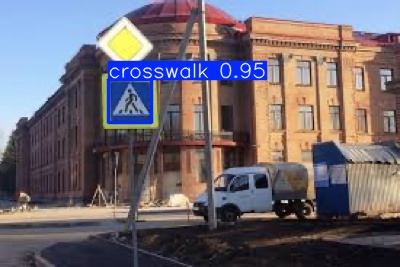

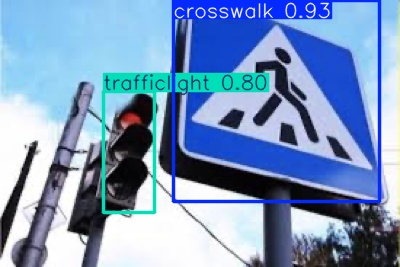

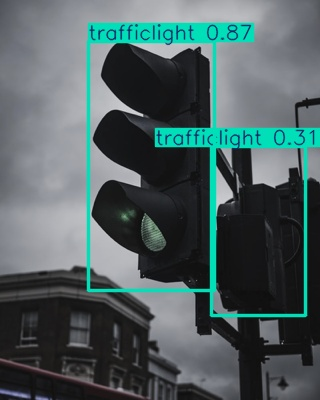

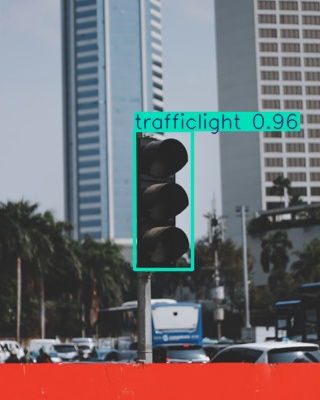

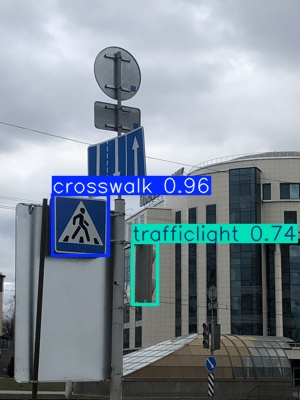

In [ ]:
from IPython.display import Image, display

display(Image(filename='runs/detect/train104/road140.jpg'))
display(Image(filename='runs/detect/train104/road156.jpg'))
display(Image(filename='runs/detect/train104/road18.jpg'))
display(Image(filename='runs/detect/train104/road20.jpg'))
display(Image(filename='runs/detect/train104/road200.jpg'))

# 4. Собственная реализация
4.ab

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import xml.etree.ElementTree as ET
from collections import Counter

def build_class_to_idx(annotations_dir):
    classes = set()

    for filename in os.listdir(annotations_dir):
        if filename.endswith('.xml'):
            xml_path = os.path.join(annotations_dir, filename)
            tree = ET.parse(xml_path)
            root = tree.getroot()

            for obj in root.findall('object'):
                class_name = obj.find('name').text
                classes.add(class_name)

    classes = sorted(list(classes))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
    return class_to_idx

annotations_dir = '/content/road-sign-detection/annotations'
class_to_idx = build_class_to_idx(annotations_dir)
class_to_idx

{'crosswalk': 0, 'speedlimit': 1, 'stop': 2, 'trafficlight': 3}

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import xml.etree.ElementTree as ET

class RoadSignDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, class_to_idx, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_filename)
        annot_path = os.path.join(self.annotations_dir, img_filename.replace('.png', '.xml'))

        image = Image.open(img_path).convert('RGB')

        orig_w, orig_h = image.size

        boxes, labels = self.parse_annotation(annot_path)

        if self.transform:
            image = self.transform(image)

        new_h, new_w = image.shape[1], image.shape[2]

        boxes = torch.tensor(boxes, dtype=torch.float32)
        scale_x = new_w / orig_w
        scale_y = new_h / orig_h
        boxes[:, [0, 2]] *= scale_x
        boxes[:, [1, 3]] *= scale_y

        labels = torch.tensor(labels, dtype=torch.long)

        target = {"boxes": boxes, "labels": labels}

        return image, target



    def parse_annotation(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        boxes = []
        labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text
            label = self.class_to_idx.get(name, -1)
            if label == -1:
                continue

            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        return boxes, labels


In [ ]:
import os
import shutil
import random

def split_dataset(base_dir, output_dir, train_ratio=0.8, val_ratio=0.2, seed=42):
    random.seed(seed)

    images_dir = os.path.join(base_dir, 'images')
    annotations_dir = os.path.join(base_dir, 'annotations')

    all_images = [f for f in os.listdir(images_dir) if f.endswith('.png')]

    random.shuffle(all_images)

    total = len(all_images)
    train_end = int(total * train_ratio)

    train_files = all_images[:train_end]
    val_files = all_images[train_end:]

    print(f"Train: {len(train_files)}, Val: {len(val_files)}")

    for split in ['train', 'val']:
        images_split_dir = os.path.join(output_dir, split, 'images')
        annotations_split_dir = os.path.join(output_dir, split, 'annotations')

        for dir_path in [images_split_dir, annotations_split_dir]:
            if os.path.exists(dir_path):
                shutil.rmtree(dir_path)
            os.makedirs(dir_path, exist_ok=True)

    def copy_files(file_list, split_name):
        for filename in file_list:
            img_src = os.path.join(images_dir, filename)
            annot_src = os.path.join(annotations_dir, filename.replace('.png', '.xml'))

            img_dst = os.path.join(output_dir, split_name, 'images', filename)
            annot_dst = os.path.join(output_dir, split_name, 'annotations', filename.replace('.png', '.xml'))

            shutil.copy(img_src, img_dst)
            shutil.copy(annot_src, annot_dst)

    copy_files(train_files, 'train')
    copy_files(val_files, 'val')

split_dataset(
    base_dir='road-sign-detection',
    output_dir='road-sign-detection-split',
    train_ratio=0.8,
    val_ratio=0.2
)


Train: 701, Val: 176


In [ ]:
transform = T.Compose([
    T.Resize((416, 416)),
    T.ToTensor(),
])
train_dataset = RoadSignDataset(
    images_dir='road-sign-detection-split/train/images',
    annotations_dir='road-sign-detection-split/train/annotations',
    class_to_idx=class_to_idx,
    transform=transform
)

val_dataset = RoadSignDataset(
    images_dir='road-sign-detection-split/val/images',
    annotations_dir='road-sign-detection-split/val/annotations',
    class_to_idx=class_to_idx,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
import torch
import torch.nn as nn

class TinyYOLOv3(nn.Module):
    def __init__(self, num_classes=4, anchors_26=2, anchors_13=2):
        super(TinyYOLOv3, self).__init__()

        def conv_bn_lrelu(in_channels, out_channels, kernel_size, stride=1):
            padding = (kernel_size - 1) // 2
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.1)
            )

        self.layer1 = conv_bn_lrelu(3, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.layer2 = conv_bn_lrelu(16, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.layer3 = conv_bn_lrelu(32, 64, 3)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.layer4 = conv_bn_lrelu(64, 128, 3)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.layer5 = conv_bn_lrelu(128, 256, 3)
        self.pool5 = nn.MaxPool2d(2, 2)

        self.layer6 = conv_bn_lrelu(256, 512, 3)
        self.pool6 = nn.MaxPool2d(2, 2, padding=1)

        self.layer7 = conv_bn_lrelu(512, 1024, 3)

        self.head_13 = nn.Sequential(
            conv_bn_lrelu(1024, 256, 1),
            conv_bn_lrelu(256, 512, 3),
            nn.Conv2d(512, anchors_13 * (5 + num_classes), 1)
        )

        self.conv_up = conv_bn_lrelu(1024, 256, 1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.head_26 = nn.Sequential(
            conv_bn_lrelu(512, 256, 3),
            nn.Conv2d(256, anchors_26 * (5 + num_classes), 1)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.pool1(x)

        x = self.layer2(x)
        x = self.pool2(x)

        x = self.layer3(x)
        x = self.pool3(x)

        x = self.layer4(x)
        x = self.pool4(x)

        x = self.layer5(x)
        route = x.clone()
        x = self.pool5(x)

        x = self.layer6(x)

        x = self.layer7(x)

        out_13 = self.head_13(x)
        up = self.conv_up(x)
        up = self.upsample(up)
        merge = torch.cat([up, route], dim=1)
        out_26 = self.head_26(merge)

        return out_13, out_26



In [ ]:
import torch.nn.functional as F

def compute_loss(pred, target, lambda_coord=5, lambda_noobj=0.5):
    mse_loss = nn.MSELoss()
    bce_loss = nn.BCEWithLogitsLoss()
    ce_loss = nn.CrossEntropyLoss()

    B, _, S, _ = pred.shape
    A = 2
    C = 4

    pred = pred.view(B, A, (5 + C), S, S).permute(0, 1, 3, 4, 2)
    target = target

    obj_mask = target[..., 4] == 1
    noobj_mask = target[..., 4] == 0

    if obj_mask.sum() > 0:
        loss_xy = mse_loss(pred[obj_mask][..., 0:2], target[obj_mask][..., 0:2])
        loss_wh = mse_loss(pred[obj_mask][..., 2:4], target[obj_mask][..., 2:4])
        loss_obj = bce_loss(pred[obj_mask][..., 4], target[obj_mask][..., 4])
        loss_class = ce_loss(pred[obj_mask][..., 5:], target[obj_mask][..., 5:].argmax(dim=-1))
    else:
        loss_xy = torch.tensor(0.0, device=pred.device)
        loss_wh = torch.tensor(0.0, device=pred.device)
        loss_obj = torch.tensor(0.0, device=pred.device)
        loss_class = torch.tensor(0.0, device=pred.device)

    loss_noobj = bce_loss(pred[noobj_mask][..., 4], target[noobj_mask][..., 4])

    loss = lambda_coord * (loss_xy + loss_wh) + loss_obj + lambda_noobj * loss_noobj + loss_class

    return loss

def bbox_iou(box1, anchors):
    inter_w = torch.min(box1[0], anchors[:, 0])
    inter_h = torch.min(box1[1], anchors[:, 1])
    inter_area = inter_w * inter_h

    union_area = (box1[0] * box1[1]) + (anchors[:, 0] * anchors[:, 1]) - inter_area
    return inter_area / (union_area + 1e-6)


def prepare_targets(targets, anchors_26, anchors_13, S_26=26, S_13=13, device='cpu'):
    num_classes = 4
    num_anchors_26 = len(anchors_26)
    num_anchors_13 = len(anchors_13)

    target_26 = torch.zeros((len(targets), num_anchors_26, S_26, S_26, 5 + num_classes), device=device)
    target_13 = torch.zeros((len(targets), num_anchors_13, S_13, S_13, 5 + num_classes), device=device)

    all_anchors = torch.tensor(anchors_26 + anchors_13, device=device)

    for b_idx, target in enumerate(targets):
        boxes = target['boxes']
        labels = target['labels']

        for box_idx in range(boxes.shape[0]):
            xmin, ymin, xmax, ymax = boxes[box_idx]

            cx = (xmin + xmax) / 2 / 416
            cy = (ymin + ymax) / 2 / 416
            w = (xmax - xmin) / 416
            h = (ymax - ymin) / 416

            gt_box = torch.tensor([w, h], device=device)
            ious = bbox_iou(gt_box, all_anchors)

            best_anchor_idx = torch.argmax(ious).item()

            if best_anchor_idx < num_anchors_26:
                anchor_idx = best_anchor_idx
                scale = S_26
                target_map = target_26
            else:
                anchor_idx = best_anchor_idx - num_anchors_26
                scale = S_13
                target_map = target_13

            grid_x = int(cx * scale)
            grid_y = int(cy * scale)

            grid_x = min(grid_x, scale - 1)
            grid_y = min(grid_y, scale - 1)

            if target_map[b_idx, anchor_idx, grid_y, grid_x, 4] == 0:
                target_map[b_idx, anchor_idx, grid_y, grid_x, 0] = cx * scale - grid_x
                target_map[b_idx, anchor_idx, grid_y, grid_x, 1] = cy * scale - grid_y
                target_map[b_idx, anchor_idx, grid_y, grid_x, 2] = w
                target_map[b_idx, anchor_idx, grid_y, grid_x, 3] = h
                target_map[b_idx, anchor_idx, grid_y, grid_x, 4] = 1.0
                target_map[b_idx, anchor_idx, grid_y, grid_x, 5 + labels[box_idx]] = 1.0

    return target_26, target_13


def train_yolo(model, train_loader, val_loader, anchors_26, anchors_13, device, num_epochs=20, patience=5):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for imgs, targets in train_loader:
            imgs = torch.stack(imgs).to(device)
            targets = list(targets)

            preds_13, preds_26 = model(imgs)

            preds_13 = preds_13.permute(0, 1, 2, 3).contiguous().to(device)
            preds_26 = preds_26.permute(0, 1, 2, 3).contiguous().to(device)

            target_26, target_13 = prepare_targets(targets, anchors_26, anchors_13, device=device)

            loss_13 = compute_loss(preds_13, target_13)
            loss_26 = compute_loss(preds_26, target_26)

            loss = loss_13 + loss_26

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {total_loss / len(train_loader):.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs = torch.stack(imgs).to(device)
                targets = list(targets)

                preds_13, preds_26 = model(imgs)
                preds_13 = preds_13.permute(0, 1, 2, 3).contiguous().to(device)
                preds_26 = preds_26.permute(0, 1, 2, 3).contiguous().to(device)

                target_26, target_13 = prepare_targets(targets, anchors_26, anchors_13, device=device)

                loss_13 = compute_loss(preds_13, target_13)
                loss_26 = compute_loss(preds_26, target_26)

                loss = loss_13 + loss_26
                val_loss += loss.item()

        print(f"[Epoch {epoch+1}/{num_epochs}] Validation Loss: {val_loss / len(val_loader):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        scheduler.step()

    return model


In [ ]:
anchors_13 = [(0.0851, 0.0736), (0.2042, 0.1751)]
anchors_26 = [(0.3377, 0.3445), (0.5736, 0.7558)]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TinyYOLOv3(num_classes=4, anchors_13=2, anchors_26=2)


train_yolo(
    model=model,
    train_loader=train_loader,
    device=device,
    anchors_13=anchors_13,
    anchors_26=anchors_26,
    val_loader=val_loader
)


[Epoch 1/20] Train Loss: 9.8787
[Epoch 1/20] Validation Loss: 4.7248
[Epoch 2/20] Train Loss: 4.3819
[Epoch 2/20] Validation Loss: 4.1830
[Epoch 3/20] Train Loss: 3.8274
[Epoch 3/20] Validation Loss: 3.8769
[Epoch 4/20] Train Loss: 3.4826
[Epoch 4/20] Validation Loss: 3.5759
[Epoch 5/20] Train Loss: 3.3124
[Epoch 5/20] Validation Loss: 3.4656
[Epoch 6/20] Train Loss: 2.7085
[Epoch 6/20] Validation Loss: 3.3973
[Epoch 7/20] Train Loss: 2.5289
[Epoch 7/20] Validation Loss: 2.8703
[Epoch 8/20] Train Loss: 2.3881
[Epoch 8/20] Validation Loss: 2.7388
[Epoch 9/20] Train Loss: 2.0315
[Epoch 9/20] Validation Loss: 2.5543
[Epoch 10/20] Train Loss: 1.7861
[Epoch 10/20] Validation Loss: 2.9680
[Epoch 11/20] Train Loss: 1.3986
[Epoch 11/20] Validation Loss: 1.7960
[Epoch 12/20] Train Loss: 1.0675
[Epoch 12/20] Validation Loss: 1.7994
[Epoch 13/20] Train Loss: 0.9758
[Epoch 13/20] Validation Loss: 1.4452
[Epoch 14/20] Train Loss: 0.9314
[Epoch 14/20] Validation Loss: 1.6064
[Epoch 15/20] Train Loss

TinyYOLOv3(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [ ]:
import numpy as np
import torch
from sklearn.metrics import average_precision_score

def decode_best_box(pred, anchors, S, device, conf_threshold=0.5):
    B, _, H, W = pred.shape
    A = len(anchors)
    C = 4  # количество классов

    pred = pred.view(B, A, (5 + C), H, W).permute(0, 1, 3, 4, 2).contiguous()

    boxes = []
    scores = []
    labels = []

    for b in range(B):
        boxes_per_image = []
        scores_per_image = []
        labels_per_image = []

        for a in range(A):
            pred_conf = pred[b, a, :, :, 4].sigmoid()
            pred_cls = pred[b, a, :, :, 5:].softmax(-1)
            pred_box = pred[b, a, :, :, :4]

            mask = pred_conf > conf_threshold

            if mask.sum() == 0:
                continue

            ys, xs = mask.nonzero(as_tuple=True)
            for y, x in zip(ys, xs):
                bx, by, bw, bh = pred_box[y, x]
                cx = (x + bx) / S
                cy = (y + by) / S
                w = bw
                h = bh

                score, label = pred_cls[y, x].max(0)
                final_score = pred_conf[y, x] * score

                boxes_per_image.append([cx, cy, w, h])
                scores_per_image.append(final_score.item())
                labels_per_image.append(label.item())

        boxes.append(boxes_per_image)
        scores.append(scores_per_image)
        labels.append(labels_per_image)

    return boxes, scores, labels

def box_iou_single(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter + 1e-6
    return inter / union

def evaluate_model(model, val_loader,
                   anchors_13, anchors_26,
                   device, conf_threshold=0.5):
    model.eval()

    num_classes = 4
    # для mAP
    y_true = {c: [] for c in range(num_classes)}
    y_scores = {c: [] for c in range(num_classes)}
    # для обычной P/R
    TP = FP = FN = 0
    all_ious = []

    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = torch.stack(imgs).to(device)
            preds_13, preds_26 = model(imgs)

            boxes_13, scores_13, labels_13 = decode_best_box(
                preds_13, anchors_13, 13, device, conf_threshold)
            boxes_26, scores_26, labels_26 = decode_best_box(
                preds_26, anchors_26, 26, device, conf_threshold)

            B = imgs.size(0)
            for i in range(B):
                boxes  = boxes_13[i]  + boxes_26[i]
                scores = scores_13[i] + scores_26[i]
                labels = labels_13[i] + labels_26[i]
                if not boxes:
                    continue

                best = int(np.argmax(scores))
                pb, ps, pl = boxes[best], scores[best], labels[best]

                px, py, pw, ph = pb
                pred_abs = [
                    (px - pw/2)*416, (py - ph/2)*416,
                    (px + pw/2)*416, (py + ph/2)*416
                ]

                gt_boxes  = targets[i]['boxes']
                gt_labels = targets[i]['labels']
                if len(gt_boxes)==0:
                    continue
                best_iou = 0; best_j = -1
                for j in range(len(gt_boxes)):
                    iou = box_iou_single(torch.tensor(pred_abs), gt_boxes[j])
                    if iou>best_iou:
                        best_iou,i = iou,j
                all_ious.append(best_iou)

                if best_iou>=0.5 and pl==gt_labels[best_j].item():
                    TP += 1
                else:
                    FP += 1
                    FN += 1

                for c in range(num_classes):
                    if pl==c:
                        y_scores[c].append(ps)
                        hit = (best_iou>=0.5 and gt_labels[best_j].item()==c)
                        y_true[c].append(int(hit))

    precision = TP/(TP+FP+1e-6)
    recall    = TP/(TP+FN+1e-6)
    mean_iou  = np.mean(all_ious) if all_ious else 0.0

    APs = []
    for c in range(num_classes):
        if len(set(y_true[c]))>1:
            APs.append(average_precision_score(y_true[c], y_scores[c]))
    mAP50 = float(np.mean(APs)) if APs else 0.0

    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"mAP@0.5  : {mAP50:.4f}")


In [ ]:
evaluate_model(model, val_loader, anchors_13, anchors_26, device)

Precision: 0.3125
Recall   : 0.3125
mAP@0.5  : 0.3264


модель показала результаты в 2 раза хуже чем yolo, это вполне понятно, так как архитектура много проще чем у yolo

улучшенный бейзлайн

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import xml.etree.ElementTree as ET
from collections import Counter

def build_class_to_idx(annotations_dir):
    classes = set()

    for filename in os.listdir(annotations_dir):
        if filename.endswith('.xml'):
            xml_path = os.path.join(annotations_dir, filename)
            tree = ET.parse(xml_path)
            root = tree.getroot()

            for obj in root.findall('object'):
                class_name = obj.find('name').text
                classes.add(class_name)

    classes = sorted(list(classes))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
    return class_to_idx

annotations_dir = '/content/road-sign-detection/annotations'
class_to_idx = build_class_to_idx(annotations_dir)
class_to_idx

{'crosswalk': 0, 'speedlimit': 1, 'stop': 2, 'trafficlight': 3}

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import xml.etree.ElementTree as ET
import albumentations as A
from albumentations.pytorch import ToTensorV2

class RoadSignDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, class_to_idx, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_filename)
        annot_path = os.path.join(self.annotations_dir, img_filename.replace('.png', '.xml'))

        # Открываем изображение через PIL, потом в np.array для albumentations
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)  # PIL -> numpy array (H, W, C)

        orig_h, orig_w = image.shape[:2]

        boxes, labels = self.parse_annotation(annot_path)

        # Приводим боксы к формату albumentations: [xmin, ymin, xmax, ymax]
        transformed = self.transform(
            image=image,
            bboxes=boxes,
            labels=labels
        )

        image = transformed['image']
        boxes = transformed['bboxes']
        labels = transformed['labels']

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        return image, target

    def parse_annotation(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        boxes = []
        labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text
            label = self.class_to_idx.get(name, -1)
            if label == -1:
                continue

            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        return boxes, labels


In [ ]:
import os
import shutil
import random

def split_dataset(base_dir, output_dir, train_ratio=0.8, val_ratio=0.2, seed=42):
    random.seed(seed)

    images_dir = os.path.join(base_dir, 'images')
    annotations_dir = os.path.join(base_dir, 'annotations')

    all_images = [f for f in os.listdir(images_dir) if f.endswith('.png')]

    random.shuffle(all_images)

    total = len(all_images)
    train_end = int(total * train_ratio)

    train_files = all_images[:train_end]
    val_files = all_images[train_end:]

    print(f"Train: {len(train_files)}, Val: {len(val_files)}")

    for split in ['train', 'val']:
        images_split_dir = os.path.join(output_dir, split, 'images')
        annotations_split_dir = os.path.join(output_dir, split, 'annotations')

        for dir_path in [images_split_dir, annotations_split_dir]:
            if os.path.exists(dir_path):
                shutil.rmtree(dir_path)
            os.makedirs(dir_path, exist_ok=True)

    def copy_files(file_list, split_name):
        for filename in file_list:
            img_src = os.path.join(images_dir, filename)
            annot_src = os.path.join(annotations_dir, filename.replace('.png', '.xml'))

            img_dst = os.path.join(output_dir, split_name, 'images', filename)
            annot_dst = os.path.join(output_dir, split_name, 'annotations', filename.replace('.png', '.xml'))

            shutil.copy(img_src, img_dst)
            shutil.copy(annot_src, annot_dst)

    copy_files(train_files, 'train')
    copy_files(val_files, 'val')

split_dataset(
    base_dir='road-sign-detection',
    output_dir='road-sign-detection-split',
    train_ratio=0.8,
    val_ratio=0.2
)


Train: 701, Val: 176


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(416, 416),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ColorJitter(p=0.3),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),  # <-- добавляем нормализацию
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_transform = A.Compose([
    A.Resize(416, 416),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

train_dataset = RoadSignDataset(
    images_dir='road-sign-detection-split/train/images',
    annotations_dir='road-sign-detection-split/train/annotations',
    class_to_idx=class_to_idx,
    transform=train_transform
)

val_dataset = RoadSignDataset(
    images_dir='road-sign-detection-split/val/images',
    annotations_dir='road-sign-detection-split/val/annotations',
    transform=val_transform,
    class_to_idx=class_to_idx
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

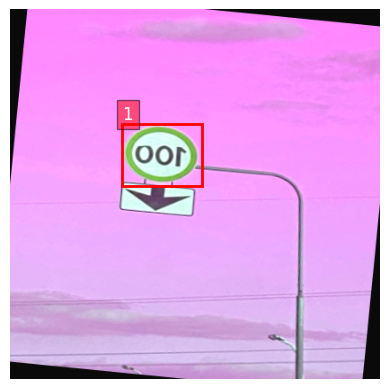

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_dataset_sample(dataset, idx):
    image, target = dataset[idx]

    # Переводим тензор изображения обратно в [0,1]
    if isinstance(image, torch.Tensor):
        image = image.permute(1,2,0).cpu().numpy()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    boxes = target['boxes']
    labels = target['labels']

    for i in range(len(boxes)):
        xmin, ymin, xmax, ymax = boxes[i]

        width = xmax - xmin
        height = ymax - ymin

        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        label = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
        ax.text(xmin, ymin - 5, str(label), color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

visualize_dataset_sample(train_dataset, idx=1)


In [ ]:
import torch.nn.functional as F

def compute_loss(pred, target, lambda_coord=5, lambda_noobj=0.5):
    mse_loss = nn.MSELoss()
    bce_loss = nn.BCEWithLogitsLoss()
    ce_loss = nn.CrossEntropyLoss()

    B, _, S, _ = pred.shape
    A = 2
    C = 4

    pred = pred.view(B, A, (5 + C), S, S).permute(0, 1, 3, 4, 2)
    target = target

    obj_mask = target[..., 4] == 1
    noobj_mask = target[..., 4] == 0

    if obj_mask.sum() > 0:
        loss_xy = mse_loss(pred[obj_mask][..., 0:2], target[obj_mask][..., 0:2])
        loss_wh = mse_loss(pred[obj_mask][..., 2:4], target[obj_mask][..., 2:4])
        loss_obj = bce_loss(pred[obj_mask][..., 4], target[obj_mask][..., 4])
        loss_class = ce_loss(pred[obj_mask][..., 5:], target[obj_mask][..., 5:].argmax(dim=-1))
    else:
        loss_xy = torch.tensor(0.0, device=pred.device)
        loss_wh = torch.tensor(0.0, device=pred.device)
        loss_obj = torch.tensor(0.0, device=pred.device)
        loss_class = torch.tensor(0.0, device=pred.device)

    loss_noobj = bce_loss(pred[noobj_mask][..., 4], target[noobj_mask][..., 4])

    loss = lambda_coord * (loss_xy + loss_wh) + loss_obj + lambda_noobj * loss_noobj + loss_class

    return loss

def bbox_iou(box1, anchors):
    inter_w = torch.min(box1[0], anchors[:, 0])
    inter_h = torch.min(box1[1], anchors[:, 1])
    inter_area = inter_w * inter_h

    union_area = (box1[0] * box1[1]) + (anchors[:, 0] * anchors[:, 1]) - inter_area
    return inter_area / (union_area + 1e-6)


def prepare_targets(targets, anchors_26, anchors_13, S_26=26, S_13=13, device='cpu'):
    num_classes = 4
    num_anchors_26 = len(anchors_26)
    num_anchors_13 = len(anchors_13)

    target_26 = torch.zeros((len(targets), num_anchors_26, S_26, S_26, 5 + num_classes), device=device)
    target_13 = torch.zeros((len(targets), num_anchors_13, S_13, S_13, 5 + num_classes), device=device)

    all_anchors = torch.tensor(anchors_26 + anchors_13, device=device)

    for b_idx, target in enumerate(targets):
        boxes = target['boxes']
        labels = target['labels']

        for box_idx in range(boxes.shape[0]):
            xmin, ymin, xmax, ymax = boxes[box_idx]

            cx = (xmin + xmax) / 2 / 416
            cy = (ymin + ymax) / 2 / 416
            w = (xmax - xmin) / 416
            h = (ymax - ymin) / 416

            gt_box = torch.tensor([w, h], device=device)
            ious = bbox_iou(gt_box, all_anchors)

            best_anchor_idx = torch.argmax(ious).item()

            if best_anchor_idx < num_anchors_26:
                anchor_idx = best_anchor_idx
                scale = S_26
                target_map = target_26
            else:
                anchor_idx = best_anchor_idx - num_anchors_26
                scale = S_13
                target_map = target_13

            grid_x = int(cx * scale)
            grid_y = int(cy * scale)

            grid_x = min(grid_x, scale - 1)
            grid_y = min(grid_y, scale - 1)

            if target_map[b_idx, anchor_idx, grid_y, grid_x, 4] == 0:
                target_map[b_idx, anchor_idx, grid_y, grid_x, 0] = cx * scale - grid_x
                target_map[b_idx, anchor_idx, grid_y, grid_x, 1] = cy * scale - grid_y
                target_map[b_idx, anchor_idx, grid_y, grid_x, 2] = w
                target_map[b_idx, anchor_idx, grid_y, grid_x, 3] = h
                target_map[b_idx, anchor_idx, grid_y, grid_x, 4] = 1.0
                target_map[b_idx, anchor_idx, grid_y, grid_x, 5 + labels[box_idx]] = 1.0

    return target_26, target_13


def train_yolo(model, train_loader, val_loader, anchors_26, anchors_13, device, num_epochs=20, patience=5):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for imgs, targets in train_loader:
            imgs = torch.stack(imgs).to(device)
            targets = list(targets)

            preds_13, preds_26 = model(imgs)

            preds_13 = preds_13.permute(0, 1, 2, 3).contiguous().to(device)
            preds_26 = preds_26.permute(0, 1, 2, 3).contiguous().to(device)

            target_26, target_13 = prepare_targets(targets, anchors_26, anchors_13, device=device)

            loss_13 = compute_loss(preds_13, target_13)
            loss_26 = compute_loss(preds_26, target_26)

            loss = loss_13 + loss_26

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {total_loss / len(train_loader):.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs = torch.stack(imgs).to(device)
                targets = list(targets)

                preds_13, preds_26 = model(imgs)
                preds_13 = preds_13.permute(0, 1, 2, 3).contiguous().to(device)
                preds_26 = preds_26.permute(0, 1, 2, 3).contiguous().to(device)

                target_26, target_13 = prepare_targets(targets, anchors_26, anchors_13, device=device)

                loss_13 = compute_loss(preds_13, target_13)
                loss_26 = compute_loss(preds_26, target_26)

                loss = loss_13 + loss_26
                val_loss += loss.item()

        print(f"[Epoch {epoch+1}/{num_epochs}] Validation Loss: {val_loss / len(val_loader):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        scheduler.step()

    return model


In [ ]:
import torch
import torch.nn as nn

class TinyYOLOv3(nn.Module):
    def __init__(self, num_classes=4, anchors_26=2, anchors_13=2):
        super(TinyYOLOv3, self).__init__()

        def conv_bn_lrelu(in_channels, out_channels, kernel_size, stride=1):
            padding = (kernel_size - 1) // 2
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.1)
            )

        self.layer1 = conv_bn_lrelu(3, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.layer2 = conv_bn_lrelu(16, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.layer3 = conv_bn_lrelu(32, 64, 3)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.layer4 = conv_bn_lrelu(64, 128, 3)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.layer5 = conv_bn_lrelu(128, 256, 3)
        self.pool5 = nn.MaxPool2d(2, 2)

        self.layer6 = conv_bn_lrelu(256, 512, 3)
        self.pool6 = nn.MaxPool2d(2, 2, padding=1)

        self.layer7 = conv_bn_lrelu(512, 1024, 3)

        self.head_13 = nn.Sequential(
            conv_bn_lrelu(1024, 256, 1),
            conv_bn_lrelu(256, 512, 3),
            nn.Conv2d(512, anchors_13 * (5 + num_classes), 1)
        )

        self.conv_up = conv_bn_lrelu(1024, 256, 1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.head_26 = nn.Sequential(
            conv_bn_lrelu(512, 256, 3),
            nn.Conv2d(256, anchors_26 * (5 + num_classes), 1)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.pool1(x)

        x = self.layer2(x)
        x = self.pool2(x)

        x = self.layer3(x)
        x = self.pool3(x)

        x = self.layer4(x)
        x = self.pool4(x)

        x = self.layer5(x)
        route = x.clone()
        x = self.pool5(x)

        x = self.layer6(x)

        x = self.layer7(x)

        out_13 = self.head_13(x)
        up = self.conv_up(x)
        up = self.upsample(up)
        merge = torch.cat([up, route], dim=1)
        out_26 = self.head_26(merge)

        return out_13, out_26



In [ ]:
import torch.nn.functional as F

def compute_loss(pred, target, lambda_coord=5, lambda_noobj=0.5):
    mse_loss = nn.MSELoss()
    bce_loss = nn.BCEWithLogitsLoss()
    ce_loss = nn.CrossEntropyLoss()

    B, _, S, _ = pred.shape
    A = 2
    C = 4

    pred = pred.view(B, A, (5 + C), S, S).permute(0, 1, 3, 4, 2)
    target = target

    obj_mask = target[..., 4] == 1
    noobj_mask = target[..., 4] == 0

    if obj_mask.sum() > 0:
        loss_xy = mse_loss(pred[obj_mask][..., 0:2], target[obj_mask][..., 0:2])
        loss_wh = mse_loss(pred[obj_mask][..., 2:4], target[obj_mask][..., 2:4])
        loss_obj = bce_loss(pred[obj_mask][..., 4], target[obj_mask][..., 4])
        loss_class = ce_loss(pred[obj_mask][..., 5:], target[obj_mask][..., 5:].argmax(dim=-1))
    else:
        loss_xy = torch.tensor(0.0, device=pred.device)
        loss_wh = torch.tensor(0.0, device=pred.device)
        loss_obj = torch.tensor(0.0, device=pred.device)
        loss_class = torch.tensor(0.0, device=pred.device)

    loss_noobj = bce_loss(pred[noobj_mask][..., 4], target[noobj_mask][..., 4])

    loss = lambda_coord * (loss_xy + loss_wh) + loss_obj + lambda_noobj * loss_noobj + loss_class

    return loss

def bbox_iou(box1, anchors):
    inter_w = torch.min(box1[0], anchors[:, 0])
    inter_h = torch.min(box1[1], anchors[:, 1])
    inter_area = inter_w * inter_h

    union_area = (box1[0] * box1[1]) + (anchors[:, 0] * anchors[:, 1]) - inter_area
    return inter_area / (union_area + 1e-6)


def prepare_targets(targets, anchors_26, anchors_13, S_26=26, S_13=13, device='cpu'):
    num_classes = 4
    num_anchors_26 = len(anchors_26)
    num_anchors_13 = len(anchors_13)

    target_26 = torch.zeros((len(targets), num_anchors_26, S_26, S_26, 5 + num_classes), device=device)
    target_13 = torch.zeros((len(targets), num_anchors_13, S_13, S_13, 5 + num_classes), device=device)

    all_anchors = torch.tensor(anchors_26 + anchors_13, device=device)

    for b_idx, target in enumerate(targets):
        boxes = target['boxes']
        labels = target['labels']

        for box_idx in range(boxes.shape[0]):
            xmin, ymin, xmax, ymax = boxes[box_idx]

            cx = (xmin + xmax) / 2 / 416
            cy = (ymin + ymax) / 2 / 416
            w = (xmax - xmin) / 416
            h = (ymax - ymin) / 416

            gt_box = torch.tensor([w, h], device=device)
            ious = bbox_iou(gt_box, all_anchors)

            best_anchor_idx = torch.argmax(ious).item()

            if best_anchor_idx < num_anchors_26:
                anchor_idx = best_anchor_idx
                scale = S_26
                target_map = target_26
            else:
                anchor_idx = best_anchor_idx - num_anchors_26
                scale = S_13
                target_map = target_13

            grid_x = int(cx * scale)
            grid_y = int(cy * scale)

            grid_x = min(grid_x, scale - 1)
            grid_y = min(grid_y, scale - 1)

            if target_map[b_idx, anchor_idx, grid_y, grid_x, 4] == 0:
                target_map[b_idx, anchor_idx, grid_y, grid_x, 0] = cx * scale - grid_x
                target_map[b_idx, anchor_idx, grid_y, grid_x, 1] = cy * scale - grid_y
                target_map[b_idx, anchor_idx, grid_y, grid_x, 2] = w
                target_map[b_idx, anchor_idx, grid_y, grid_x, 3] = h
                target_map[b_idx, anchor_idx, grid_y, grid_x, 4] = 1.0
                target_map[b_idx, anchor_idx, grid_y, grid_x, 5 + labels[box_idx]] = 1.0

    return target_26, target_13


def train_yolo(model, train_loader, val_loader, anchors_26, anchors_13, device, num_epochs=20, patience=5):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for imgs, targets in train_loader:
            imgs = torch.stack(imgs).to(device)
            targets = list(targets)

            preds_13, preds_26 = model(imgs)

            preds_13 = preds_13.permute(0, 1, 2, 3).contiguous().to(device)
            preds_26 = preds_26.permute(0, 1, 2, 3).contiguous().to(device)

            target_26, target_13 = prepare_targets(targets, anchors_26, anchors_13, device=device)

            loss_13 = compute_loss(preds_13, target_13)
            loss_26 = compute_loss(preds_26, target_26)

            loss = loss_13 + loss_26

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {total_loss / len(train_loader):.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs = torch.stack(imgs).to(device)
                targets = list(targets)

                preds_13, preds_26 = model(imgs)
                preds_13 = preds_13.permute(0, 1, 2, 3).contiguous().to(device)
                preds_26 = preds_26.permute(0, 1, 2, 3).contiguous().to(device)

                target_26, target_13 = prepare_targets(targets, anchors_26, anchors_13, device=device)

                loss_13 = compute_loss(preds_13, target_13)
                loss_26 = compute_loss(preds_26, target_26)

                loss = loss_13 + loss_26
                val_loss += loss.item()

        print(f"[Epoch {epoch+1}/{num_epochs}] Validation Loss: {val_loss / len(val_loader):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        scheduler.step()

    return model


In [ ]:
anchors_13 = [(0.0851, 0.0736), (0.2042, 0.1751)]
anchors_26 = [(0.3377, 0.3445), (0.5736, 0.7558)]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TinyYOLOv3(num_classes=4, anchors_13=2, anchors_26=2)

train_yolo(
    model=model,
    train_loader=train_loader,
    device=device,
    anchors_13=anchors_13,
    anchors_26=anchors_26,
    val_loader=val_loader
)


[Epoch 1/20] Train Loss: 10.4667
[Epoch 1/20] Validation Loss: 4.8663
[Epoch 2/20] Train Loss: 4.6232
[Epoch 2/20] Validation Loss: 4.1981
[Epoch 3/20] Train Loss: 4.1334
[Epoch 3/20] Validation Loss: 4.2106
[Epoch 4/20] Train Loss: 3.9622
[Epoch 4/20] Validation Loss: 3.6534
[Epoch 5/20] Train Loss: 3.8419
[Epoch 5/20] Validation Loss: 3.5256
[Epoch 6/20] Train Loss: 3.5682
[Epoch 6/20] Validation Loss: 3.4843
[Epoch 7/20] Train Loss: 3.3680
[Epoch 7/20] Validation Loss: 7.7285
[Epoch 8/20] Train Loss: 3.3488
[Epoch 8/20] Validation Loss: 2.9154
[Epoch 9/20] Train Loss: 3.0231
[Epoch 9/20] Validation Loss: 2.4173
[Epoch 10/20] Train Loss: 2.6130
[Epoch 10/20] Validation Loss: 2.1767
[Epoch 11/20] Train Loss: 2.2325
[Epoch 11/20] Validation Loss: 1.9207
[Epoch 12/20] Train Loss: 1.9529
[Epoch 12/20] Validation Loss: 1.9153
[Epoch 13/20] Train Loss: 1.9402
[Epoch 13/20] Validation Loss: 1.7299
[Epoch 14/20] Train Loss: 1.7855
[Epoch 14/20] Validation Loss: 1.7942
[Epoch 15/20] Train Los

TinyYOLOv3(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

лосс уменьшился на улучшенном бейзлайне

In [ ]:
import numpy as np
import torch
from sklearn.metrics import average_precision_score

def decode_best_box(pred, anchors, S, device, conf_threshold=0.5):
    B, _, H, W = pred.shape
    A = len(anchors)
    C = 4  # количество классов

    pred = pred.view(B, A, (5 + C), H, W).permute(0, 1, 3, 4, 2).contiguous()

    boxes = []
    scores = []
    labels = []

    for b in range(B):
        boxes_per_image = []
        scores_per_image = []
        labels_per_image = []

        for a in range(A):
            pred_conf = pred[b, a, :, :, 4].sigmoid()
            pred_cls = pred[b, a, :, :, 5:].softmax(-1)
            pred_box = pred[b, a, :, :, :4]

            mask = pred_conf > conf_threshold

            if mask.sum() == 0:
                continue

            ys, xs = mask.nonzero(as_tuple=True)
            for y, x in zip(ys, xs):
                bx, by, bw, bh = pred_box[y, x]
                cx = (x + bx) / S
                cy = (y + by) / S
                w = bw
                h = bh

                score, label = pred_cls[y, x].max(0)
                final_score = pred_conf[y, x] * score

                boxes_per_image.append([cx, cy, w, h])
                scores_per_image.append(final_score.item())
                labels_per_image.append(label.item())

        boxes.append(boxes_per_image)
        scores.append(scores_per_image)
        labels.append(labels_per_image)

    return boxes, scores, labels

def box_iou_single(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter + 1e-6
    return inter / union

def evaluate_model(model, val_loader,
                   anchors_13, anchors_26,
                   device, conf_threshold=0.5):
    model.eval()

    num_classes = 4
    # для mAP
    y_true = {c: [] for c in range(num_classes)}
    y_scores = {c: [] for c in range(num_classes)}
    # для обычной P/R
    TP = FP = FN = 0
    all_ious = []

    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = torch.stack(imgs).to(device)
            preds_13, preds_26 = model(imgs)

            boxes_13, scores_13, labels_13 = decode_best_box(
                preds_13, anchors_13, 13, device, conf_threshold)
            boxes_26, scores_26, labels_26 = decode_best_box(
                preds_26, anchors_26, 26, device, conf_threshold)

            B = imgs.size(0)
            for i in range(B):
                boxes  = boxes_13[i]  + boxes_26[i]
                scores = scores_13[i] + scores_26[i]
                labels = labels_13[i] + labels_26[i]
                if not boxes:
                    continue

                best = int(np.argmax(scores))
                pb, ps, pl = boxes[best], scores[best], labels[best]

                px, py, pw, ph = pb
                pred_abs = [
                    (px - pw/2)*416, (py - ph/2)*416,
                    (px + pw/2)*416, (py + ph/2)*416
                ]

                gt_boxes  = targets[i]['boxes']
                gt_labels = targets[i]['labels']
                if len(gt_boxes)==0:
                    continue
                best_iou = 0; best_j = -1
                for j in range(len(gt_boxes)):
                    iou = box_iou_single(torch.tensor(pred_abs), gt_boxes[j])
                    if iou>best_iou:
                        best_iou,i = iou,j
                all_ious.append(best_iou)

                if best_iou>=0.5 and pl==gt_labels[best_j].item():
                    TP += 1
                else:
                    FP += 1
                    FN += 1

                for c in range(num_classes):
                    if pl==c:
                        y_scores[c].append(ps)
                        hit = (best_iou>=0.5 and gt_labels[best_j].item()==c)
                        y_true[c].append(int(hit))

    precision = TP/(TP+FP+1e-6)
    recall    = TP/(TP+FN+1e-6)
    mean_iou  = np.mean(all_ious) if all_ious else 0.0

    APs = []
    for c in range(num_classes):
        if len(set(y_true[c]))>1:
            APs.append(average_precision_score(y_true[c], y_scores[c]))
    mAP50 = float(np.mean(APs)) if APs else 0.0

    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"mAP@0.5  : {mAP50:.4f}")


In [ ]:
evaluate_model(model, val_loader, anchors_13, anchors_26, device)

Precision: 0.4148
Recall   : 0.4148
mAP@0.5  : 0.6371


4.h Модель на улучшенном бейзлайне показала неплохие результаты, но все равно сильно хуже чем у yolo. Но метрики на улучшенном бейзлайне и на собственной реализации, и на yolo лучше \
4.j модель показала результат хуже в 2 раза чем yolo, это объсняется более простой архитектурой со сравнению yolo